 
### svGPFA uses sparse variational approximations based on inducing points to infer a set of latent factors <br> that vary over time, from spike timing observation of multiple neurons.

### Here, we simulate spike times from a 'ground truth' latent process. The observation process is considered <br> to factor into two sets of observations, emulating two groups of neurons from two different brain areas. <br> We then fit sVGPFA to the spike times to recover the latents.


In [17]:
import os
import jax.numpy as jnp
import numpy as np
import jax
from src.loss import objective_fn, objective_fn_twoarea, compute_mean_factor
from src.cholesky import vmapped_lower_triangular
from src.quadrature import getLegQuadPointsAndWeights
from src.kernel import precompute_Kzz
from src.latents import compute_latent_means
import jaxopt
import time
import matplotlib.pyplot as plt
import math
import scipy

In [6]:
seed = np.random.randint(low = 42, high = 450000)
key = jax.random.PRNGKey(seed)
rng = np.random.default_rng(42)

In [7]:
def simulate_spikes_from_rates(rates, T, n_trials, ngrid):


    def sample_inhomogenous(rate, T, ngrid):

        """ Simulate spike trains from an inhomogenous poisson process
         given a certain rate function

         rate : lambda function that evaluates the rate at a grid of input points
         T : total number of times in a trial
         ngrid: number of grid points between (0,T)      
        
        """


        x = np.linspace(0,T,num=ngrid)
        lam0 = np.amax(rate(x))
        u = rng.uniform(size=(np.ceil(1.5*T*lam0).astype(np.int64),))
        x = np.cumsum(-(1/lam0)* np.log(u))
        x = x[x<T]
        n=sum(x<T)
        l = rate(x)
        x = x[rng.uniform(size=(n,)) < l/lam0]
        return x

    n_neurons = len(rates)
    sps = []
    for m in range(n_trials):
        sps_m = []
        for i in range(n_neurons):
            sps_m.append(sample_inhomogenous(rates[i], T, ngrid))
        
        sps.append(sps_m)

    return sps

def preprocess_data(spikes):
    """ Preprocess neural pop. spike times into a data structure
        that is amenable to svGPFA fitting.  
    """
    spike_times = dict()
    trunc_indices = dict()
    max_spikes = []
    n_spikes = []
    n_trials = len(spikes)
    n_neurons = len(spikes[0])
    for i in range(n_neurons):
        n_spikes_i = []
        for j in range(n_trials):
            n_spikes_i.append(len(spikes[j][i]))
        max_spikes.append(np.amax(np.asarray(n_spikes_i)))
        n_spikes.append(n_spikes_i)

    for i in range(n_neurons):

        spike_time_matrix = np.empty((n_trials,max_spikes[i]))
        spike_time_matrix[:] = np.nan
        
        for j in range(n_trials):
            spike_time_matrix[j,:n_spikes[i][j]] = spikes[j][i]

        spike_times[f'Unit-{i+1}'] = jnp.asarray(spike_time_matrix)
        trunc_indices[f'Unit-{i+1}'] = jnp.asarray(n_spikes[i])

    pad_fn = lambda x: jnp.nan_to_num(x,nan=1e9)
    spike_times = {k:pad_fn(v) for k, v in spike_times.items()}
    return spike_times, trunc_indices

def initialize_observationmodel_params_blocked(key, n_neurons, n_latents):

    """ Initialize prameters of observation model (block diagonal construction),
        Ci loadings for area 'i' onto latents
    """

    key, subkey1, subkey2, subkey3 = jax.random.split(key, 4)
    C1 = jax.random.normal(key = subkey1, shape = (n_neurons[0], n_latents[0]))*0.1
    C2 = jax.random.normal(key = subkey2, shape = (n_neurons[1], n_latents[1]))*0.1
    d = jax.random.normal(key = subkey3, shape = (n_neurons[0] + n_neurons[1], 1))*0.1
    dummy_dict = dict()
    for n in range(sum(n_neurons)):
        dummy_dict[f'Unit-{n+1}'] = jnp.asarray(n)
    return C1, C2, d, dummy_dict, key

def initialize_observationmodel_params(key, n_neurons, n_latents):

    """ Initialize parameters of observation model (vanilla)"""

    key, subkey1, subkey2 = jax.random.split(key, 3)
    C = jax.random.normal(key = subkey1, shape = (n_neurons, n_latents))*0.1
    d = jax.random.normal(key = subkey2, shape = (n_neurons, 1))*0.1
    dummy_dict = dict()
    for n in range(n_neurons):
        dummy_dict[f'Unit-{n+1}'] = jnp.asarray(n)
    return C, d, dummy_dict, key       

def initialize_inducing_points(T, n_ind_points ,n_latents):

    """ Initialize inducing points for GP inference """

    ind_points_locs = jnp.linspace(0, T, n_ind_points)
    ind_points_locs = jnp.repeat(ind_points_locs[jnp.newaxis,:], n_latents, axis=0)
    return ind_points_locs

def initialize_kernel_params(n_latents,sigma=1):
    return sigma * jnp.ones((n_latents,))

def initialize_variational_params(key, n_ind_points, n_latents, n_trials):
    key, subkey = jax.random.split(key)
    vMean = jax.random.normal(key = subkey, shape = (n_latents,n_trials,n_ind_points,))
    vCov = 1e-2*jnp.eye(n_ind_points)
    vCov = vCov[jnp.newaxis,jnp.newaxis,...]
    vCov = jnp.repeat(vCov,repeats=n_latents,axis=0)
    vCov = jnp.repeat(vCov,repeats=n_trials,axis=1)
    vChol = jax.scipy.linalg.cholesky(vCov,lower=True)
    vChol = vmapped_lower_triangular(vChol)
    return vMean, vChol, key

In [11]:
# Setting all the parameters

MAX_EM_ITER = 5000
do_fit_block = True
fit_params = dict(n_latents_1 = 2,
                      n_latents_2 = 2,
                      n_ind_points = 10,
                      n_quad = 100)

data_params = dict(n_neurons_1 = 35,
                    n_neurons_2 = 45,
                    n_trials = 50,
                    max_trial_length = 20,
                    n_grid = 2000)
    
optim_params = dict(tol = 1e-6,
                    maxiter = MAX_EM_ITER, 
                    max_stepsize=1.0, 
                    jit = True
                    )

n_total_neurons = data_params['n_neurons_1'] + data_params['n_neurons_2']
n_total_latents = fit_params['n_latents_1'] + fit_params['n_latents_2']
n_neurons = [data_params['n_neurons_1'], data_params['n_neurons_2']]
n_latents = [fit_params['n_latents_1'], fit_params['n_latents_2']]

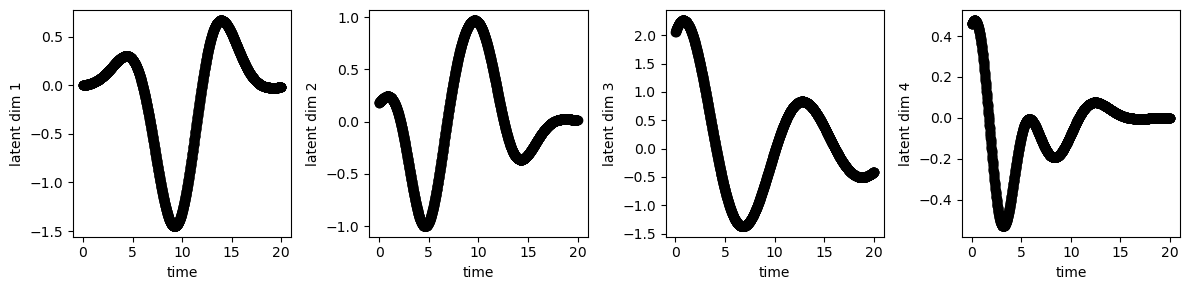

In [26]:
# Plotting the true latents that give rise to spike time observations. Here, we simulate a 4-dimensional latent process.
# Each latent process is some complex, non-linear function of time, which gets expressed as a pattern of population
# spike time patterns through a poisson observation process.

time_est = np.linspace(0,data_params['max_trial_length'],data_params['n_grid'])

latent_func_1 = lambda t: 1.5 * np.exp(-0.5 *((t-10) ** 2 / 12)) * np.sin(2 * math.pi * (1/12) * t)
latent_func_2 = lambda t: 0.8 * np.exp(-0.5*((t-5) ** 2/8)) * np.cos(2 * math.pi * .12 * t )  + 0.9 * np.exp(-0.5 * ((t-10)**2/12)) * np.sin(2 * math.pi * t * 0.1 + 1.5)

latent_func_3 = lambda t: 0.9 * np.exp(-0.5*((t-12) ** 1/6)) * np.sin(2 * math.pi * (1/12) * t + 1.0)
latent_func_4 = lambda t: 0.8 * np.exp(-0.5*((t-2) ** 2/4)) * np.cos(2 * math.pi * .12 * t + 0.3 )  + 0.2 * np.exp(-0.5 * ((t-8)**2/12)) * np.sin(2 * math.pi * t * 0.1 - 0.5)


fig, axs = plt.subplots(nrows=1,ncols=4,sharex=True, figsize = (12,3))
axs[0].scatter(time_est,latent_func_1(time_est),c='k')
axs[1].scatter(time_est,latent_func_2(time_est),c='k')
axs[2].scatter(time_est,latent_func_3(time_est),c='k')
axs[3].scatter(time_est,latent_func_4(time_est),c='k')
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel('time')
    ax.set_ylabel(f'latent dim {i+1}')
fig.tight_layout()

In [10]:
trueC1 = rng.normal(size= (data_params['n_neurons_1'],fit_params['n_latents_1']))
trueC1 = trueC1 * np.asarray([[1.2,1.3]])
trueC1 = 0.4*trueC1

trueC2 = rng.normal(size = (data_params['n_neurons_2'],fit_params['n_latents_2']))
trueC2 = trueC2 * np.asarray([[1.2,1.3]])
trueC2 = 0.4*trueC2

trueC = scipy.linalg.block_diag(trueC1,trueC2)
trued = -0.1*np.ones((n_total_neurons,1))
    
rate_functions = []
for n in range(n_total_neurons):
    rate_functions.append(lambda t, n=n: np.exp(np.matmul(trueC[n,:], np.stack([latent_func_1(t), latent_func_2(t),latent_func_3(t),latent_func_4(t)])) + trued[n]))

spikes = simulate_spikes_from_rates(rate_functions, data_params['max_trial_length'], data_params['n_trials'], data_params['n_grid'])

spike_times, trunc_indices = preprocess_data(spikes)


In [ ]:
# Initializing the parameters

params0 = dict()
params0['kernel_params'] = initialize_kernel_params(n_total_latents)

quad = dict()
quad['points'], quad['weights'] = getLegQuadPointsAndWeights(fit_params['n_quad'], \
                                                np.zeros((data_params['n_trials'],)),\
                                                data_params['max_trial_length']*np.ones((data_params['n_trials'],)))

params0['vMean'], params0['vChol'], key  = initialize_variational_params(key,fit_params['n_ind_points'],n_total_latents,data_params['n_trials'])

if do_fit_block:
    params0['C1'],params0['C2'],params0['d'],dummy_dict,key = initialize_observationmodel_params_blocked(key,n_neurons,n_latents)
    free_energy = objective_fn_twoarea(spike_times, quad, trunc_indices, dummy_dict)
else:
    params0['C'], params0['d'],dummy_dict, key = initialize_observationmodel_params(key,n_total_neurons,n_total_latents)
    free_energy = objective_fn(spike_times, quad, trunc_indices, dummy_dict)

params0['ind_points_locs'] = initialize_inducing_points(data_params['max_trial_length'],fit_params['n_ind_points'],n_total_latents)

In [12]:
# Running the ELBO optimization. Definitely run this on a GPU if you want JAX speedups

start_time = time.time()

solver = jaxopt.LBFGS(fun= free_energy, **optim_params)
print(f'Initializing LBFGS solver ....')
# get_gpu_memory()
optim_state = solver.init_state(params0)
# get_gpu_memory()
print(f'Completed Initializing LBFGS solver')
params = params0
lb = -free_energy(params0)
print(f'ElBO at initialization ={lb}')
lower_bound_hist = [lb]
elapsed_time_hist = []
start_time_iter = time.time()
# running_mean = 0.0

for step in range(MAX_EM_ITER):
    params, optim_state = solver.update(params= params, state=optim_state)
    lb = -optim_state.value.item()
    lower_bound_hist.append(lb)
    elapsed_time_hist.append(time.time() - start_time_iter)
    print(f"Iteration {step}: {lb}")

elapsed_time = time.time() - start_time
print(f"elapsed time={elapsed_time}")
result = {"params":params, "state":optim_state, "elapsed_time_hist": elapsed_time_hist, "lower_bound_hist": lower_bound_hist, "seed":seed, "fit_type": do_fit_block}

Initializing LBFGS solver ....
Completed Initializing LBFGS solver
ElBO at initialization =-85905.4765625


2025-01-19 15:54:14.210660: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_update] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-01-19 15:56:15.267488: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 4m1.057070384s

********************************
[Compiling module jit_update] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


Iteration 0: -83630.2734375
Iteration 1: -83596.0390625
Iteration 2: -83498.6953125
Iteration 3: -83330.953125
Iteration 4: -83080.59375
Iteration 5: -82711.2265625
Iteration 6: -82187.0859375
Iteration 7: -81379.96875
Iteration 8: -80327.90625
Iteration 9: -79976.90625
Iteration 10: -79824.46875
Iteration 11: -79760.1015625
Iteration 12: -79727.953125
Iteration 13: -79709.8984375
Iteration 14: -79695.6640625
Iteration 15: -79682.8125
Iteration 16: -79656.8671875
Iteration 17: -79596.34375
Iteration 18: -79550.46875
Iteration 19: -79454.9921875
Iteration 20: -79396.375
Iteration 21: -79283.4765625
Iteration 22: -79094.234375
Iteration 23: -78848.359375
Iteration 24: -78380.0390625
Iteration 25: -77991.3984375
Iteration 26: -77660.09375
Iteration 27: -77276.40625
Iteration 28: -77182.0625
Iteration 29: -76584.2265625
Iteration 30: -76407.2109375
Iteration 31: -76244.953125
Iteration 32: -76115.4921875
Iteration 33: -75889.796875
Iteration 34: -75686.8828125
Iteration 35: -75513.484375
I

Text(0, 0.5, 'ELBO')

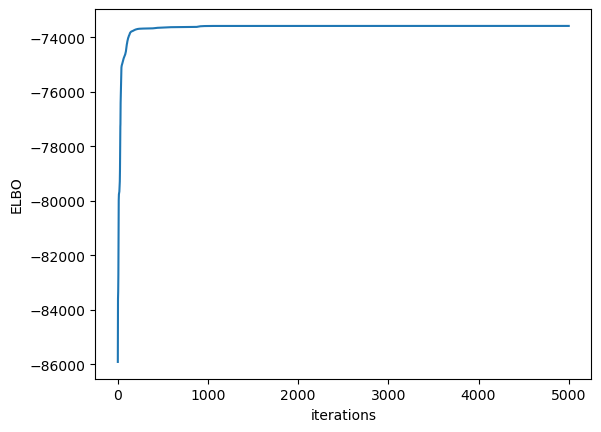

In [14]:
plt.figure()
plt.plot([jnp.where(i >-1e5,i,jnp.nan) for i in result['lower_bound_hist']])
plt.xlabel('iterations')
plt.ylabel('ELBO')

In [40]:
# Inferring the latent states using the learned model parameters
time_est = jnp.linspace(0,data_params['max_trial_length'],data_params['n_grid'])
time_est = time_est[jnp.newaxis,:]
time_est = jnp.repeat(time_est,data_params["n_trials"],axis=0)
Kzz_est = precompute_Kzz(result['params']['ind_points_locs'], result['params']['kernel_params'])
Kzz_cho_est = jax.scipy.linalg.cholesky(Kzz_est,lower=True)
mean_factor = compute_mean_factor(Kzz_cho_est, result['params']['vMean'])
latent_means_est = compute_latent_means(result['params']['kernel_params'],result['params']['ind_points_locs'],mean_factor,time_est)

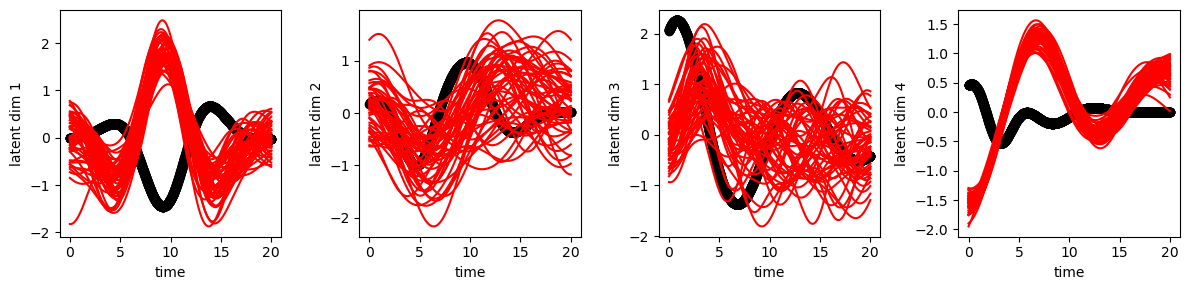

In [50]:
# This plot shows the true (black) and estiamted (red) latent time courses.
# Note that latents can only be obtained upto a permutation and sign. 
fig, axs = plt.subplots(nrows=1,ncols=4,sharex=True,figsize = (12,3))
axs[0].scatter(time_est[0],latent_func_1(time_est[0]),c='k')
axs[0].plot(time_est[0],latent_means_est[0].T,'-r');
axs[1].scatter(time_est[0],latent_func_2(time_est[0]),c='k')
axs[1].plot(time_est[0],latent_means_est[1].T,'-r');
axs[2].scatter(time_est[0],latent_func_3(time_est[0]),c='k')
axs[2].plot(time_est[0],latent_means_est[2].T,'-r');
axs[3].scatter(time_est[0],latent_func_4(time_est[0]),c='k')
axs[3].plot(time_est[0],latent_means_est[3].T,'-r');
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel('time')
    ax.set_ylabel(f'latent dim {i+1}')
fig.tight_layout()
# plt.plot(time_est[0],latent_means_est[1,0,:])